# Assignment 1

#### Group 30:

Aleksandar Lukic, s19

Clara Mejlhede Lorenzen, s180350

Julia Katarzyna Zalewska, s24

## Part 1: Exploring the friendship paradox.

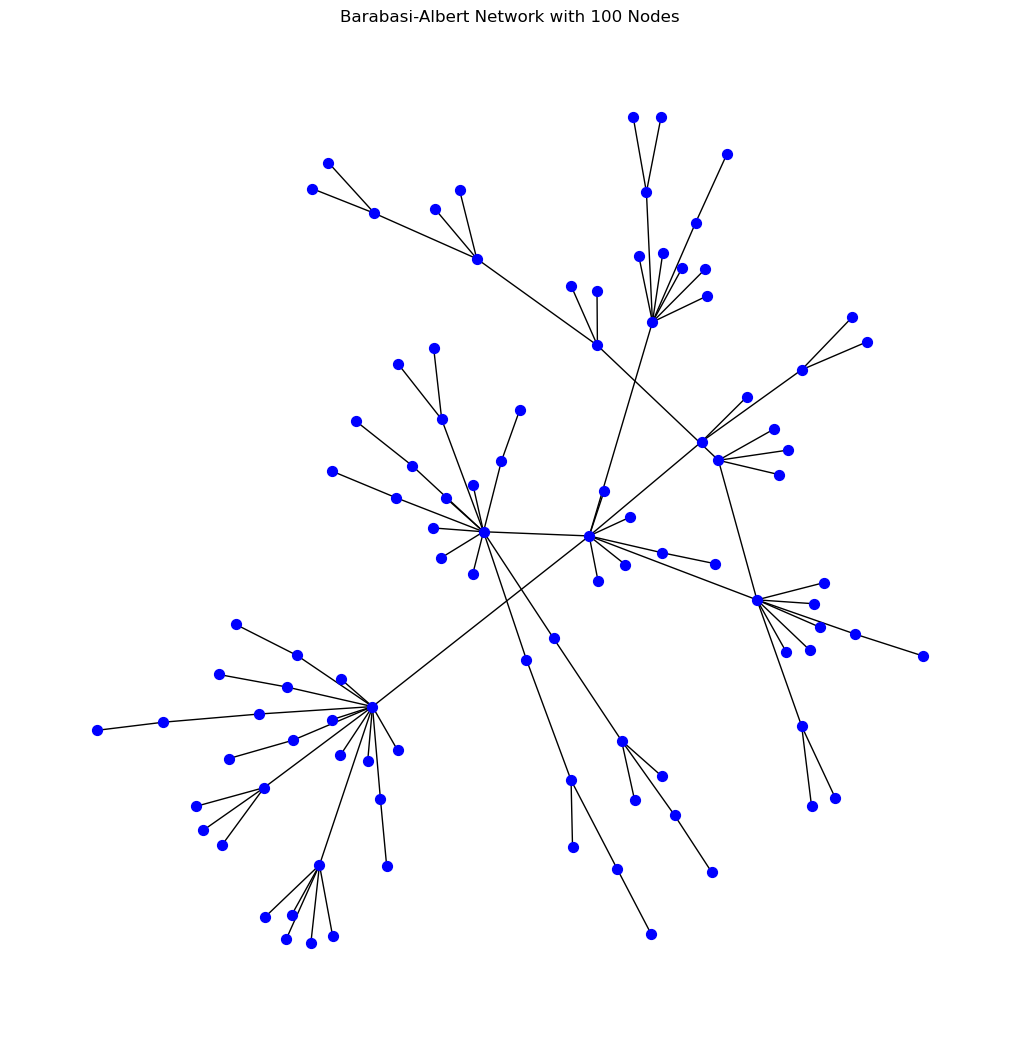

In [27]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np

# Create an initial graph with a single link (connecting 0 and 1)
G = nx.Graph()
G.add_edge(0, 1)

# Add nodes, connecting each to the existing nodes with probability proportional to their degree
def add_node_with_preferential_attachment(G, new_node):
    
    degrees = [node for node, degree in G.degree() for _ in range(degree)]
    
    # attach the new node to existing node
    chosen_node = random.choice(degrees)
    G.add_edge(new_node, chosen_node)

# Keep going until you have a 100 node network.
for i in range(2, 100):
    add_node_with_preferential_attachment(G, i)

# Plot the network
plt.figure(figsize=(10, 10))
nx.draw(G, node_size=50, node_color='blue', with_labels=False)
plt.title('Barabasi-Albert Network with 100 Nodes')
plt.show()

Maximum Degree: 122
Minimum Degree: 1


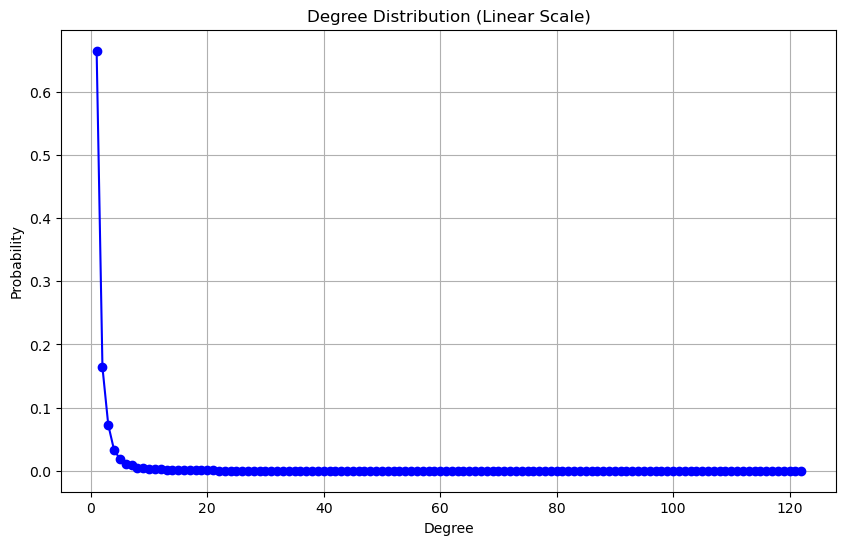

In [28]:
# Add more nodes until you have a 5000 node network.
for i in range(100, 5000):
    add_node_with_preferential_attachment(G, i)

# What's the maximum and minimum degree?
degrees = [degree for node, degree in G.degree()]
max_degree = max(degrees)
min_degree = min(degrees)

print(f"Maximum Degree: {max_degree}")
print(f"Minimum Degree: {min_degree}")

# Bin the degree distribution using numpy.histogram.
hist, bin_edges = np.histogram(degrees, bins=range(min_degree, max_degree + 2), density=True)

# Plot the distribution in linear 
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], hist, 'b-', marker='o')
plt.xlabel('Degree')
plt.ylabel('Probability')
plt.title('Degree Distribution (Linear Scale)')
plt.grid(True)
plt.show()

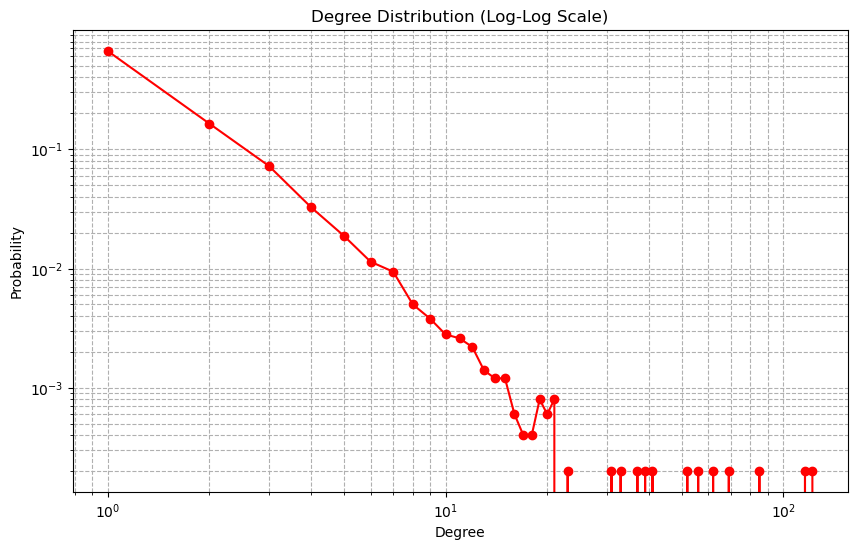

In [29]:
# Plot the distribution in log-log axes.
plt.figure(figsize=(10, 6))
plt.loglog(bin_edges[:-1], hist, 'r-', marker='o')
plt.xlabel('Degree')
plt.ylabel('Probability')
plt.title('Degree Distribution (Log-Log Scale)')
plt.grid(True, which="both", ls="--")
plt.show()

#### The friendship paradox in BA networks

       Pick a node i at random (e.g. use random.choice). Find its degree.

In [3]:
# Find random node i 
random_node = random.choice(list(G.nodes))

# Find its degree
node_degree = G.degree[random_node]
print(f"Degree of node_i {random_node}: {node_degree}")

Degree of node_i 2073: 1


        Find i's neighbors. And calculate their average degree.

In [4]:
# Find neighbors and their degrees
neighbors = list(G.neighbors(random_node))
neighbor_degrees = [G.degree[neighbor] for neighbor in neighbors]

# Calculate neighbors_degree 
if len(neighbor_degrees) > 0:
    neighbor_degree = sum(neighbor_degrees) / len(neighbor_degrees)
else:
    neighbor_degree = 0

print(f"Degree of neighbor_i {random_node}: {neighbor_degree}")

Degree of neighbor_i 2073: 13.0


        Compare the two numbers to check if it's true that i's friends (on average) have more friends than i.

In [5]:
if node_degree < neighbor_degree:
    print("It is true, i's friends has more friends than i") 
else:
    print("It is not true, i has more friends than i's friends")

It is true, i's friends has more friends than i


        Do this 1000 times. How many out of those 1000 times is the friendship paradox true in F-BA?

In [6]:
t = 0
f = 0

for i in range(1000):
    # Find random node i 
    random_node = random.choice(list(G.nodes))

    # Find its degree
    node_degree = G.degree[random_node]    
    
    # Find neighbors and their degrees
    neighbors = list(G.neighbors(random_node))
    neighbor_degrees = [G.degree[neighbor] for neighbor in neighbors]

    # Calculate neighbors_degree 
    if len(neighbor_degrees) > 0:
        neighbor_degree = sum(neighbor_degrees) / len(neighbor_degrees)
    else:
        neighbor_degree = 0
    
    if node_degree < neighbor_degree:
        t += 1 
    else:
        f += 1

print(f"The friendship paradox is true {t} times and false {f} times out of 1000 times in total")

The friendship paradox is true 860 times and false 140 times out of 1000 times in total


#### The friendship paradox more generally

        What if the power law is flatter, e.g. p(k)∼k^(−γ) with γ=2? Will the fraction of times the paradox is true be 
        higher or lower?

Since the power-law distribution is skewed, when γ=2, the fraction of times the paradox is true will be higher. 

    For a steep power-law, the nodes will have low degrees, and only a few hubs will exist.

    For a flatter power-law, there are more high-degree nodes, meaning that many more nodes are relatively well-connected.

        First answer this question by simply reasoning. Think about what it would mean in terms of hubs that the power law 
        is flatter?

With a flatter power law, the gap between a node and the hubs is smaller because hubs will be more common. 

A randomly chosen node is likely to have neighbors with similar degrees. Therefore, the Friendship Paradox (the idea that your friends have more friends than you) will hold more frequently since there are many well-connected nodes in the neighborhood of any given node.

        Now simulate a new network with the slope mentioned above. You can generate networks with power-law degree 
        distributions using the configuation model. The networkx funtion is here nx.configuration_model. I suggest you make 
        the network pretty big ... let's say 5000 nodes or more.

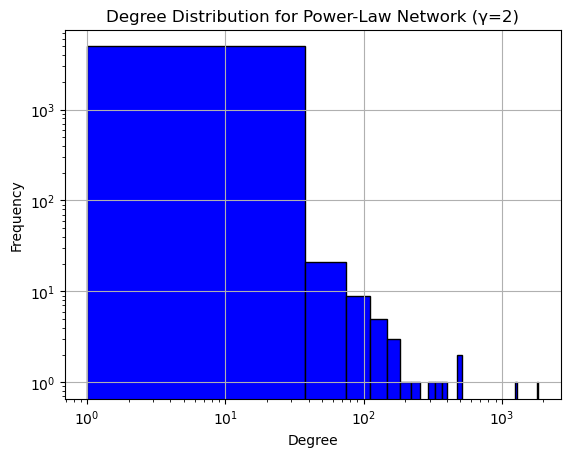

In [31]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

n = 5000
gamma = 2

# Degrees following p(k) ~ k^(-gamma)
degree_sequence = np.random.zipf(gamma, n)

# Ensure the sum of degrees is even
if sum(degree_sequence) %  2 != 0:
    degree_sequence[0] += 1

# Create the configuration model graph
G = nx.configuration_model(degree_sequence)

# Remove parallel edges and self-loops
G = nx.Graph(G)
G.remove_edges_from(nx.selfloop_edges(G))

# Plot the degree distribution
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=50, color='blue', edgecolor='black')

plt.title('Degree Distribution for Power-Law Network (γ=2)')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

        Did you reason correctly above? For what fraction of the time is the friendship paradox true for your network with a 
        new slope?

In [32]:
import random
import numpy as np

# Initialize counts for the friendship paradox
paradox_true = 0
paradox_false = 0

# Testing the test x times
x = 1000

for _ in range(x):
    
    random_node = random.choice(list(G.nodes))

    node_degree = G.degree[random_node]

    neighbors = list(G.neighbors(random_node))
    
    # Find the degree of neighbors
    if len(neighbors) > 0:
        neighbor_degrees = [G.degree[neighbor] for neighbor in neighbors]
        avg_neighbor_degree = np.mean(neighbor_degrees)
    else:
        avg_neighbor_degree = 0
    
    # Checking if friendship paradox holds
    if node_degree < avg_neighbor_degree:
        paradox_true += 1
    else:
        paradox_false += 1

fraction_true = paradox_true / (paradox_true + paradox_false)
print(f"Friendship Paradox is true {fraction_true*100}% of the time")

Friendship Paradox is true 97.2% of the time


#### The friendship paradox and the configuration model

        Now generate a network for the configuration model that has the same slope and number of nodes as F-BA* in A above;
        let's call this new network F-CM* (for friendship configuration model).

#### Growth without preferential attachment

        Finally, we'll build a network of same size and degree as in the exercise above, using the growth mechanism without 
        the preferential attachment. Follow the steps below for success

## Part 2: Stats of the Country Music Network